# 株価予測モデル

## データ概要
    - データ内容:株価日足データ（時系列）　<- SIGNATE 練習課題
    - 課題種別：分類
    - データ種別：多変量
    - 学習データサンプル数：2026
    - 説明変数の数：4
    - 欠損値：無し
    - 予測対象: 各6日分の公開データ最終日のカラム['Up'] -> 株価が上がるか下がるかの分類
    - 精度評価：Accuracy

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from scipy import signal, stats, linalg, integrate
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [210]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [211]:
df_train

,Date,Open,High,Low,Close,Up
0,2004-01-02,50.85,50.91,50.62,50.72,1
1,2004-01-05,50.75,50.84,50.61,50.79,1
2,2004-01-06,50.87,51.26,50.86,51.15,1
3,2004-01-07,51.45,51.54,51.29,51.51,0
4,2004-01-08,51.15,51.33,51.02,51.28,0
...,...,...,...,...,...,...
2021,2012-01-11,108.62,109.00,108.41,108.86,1
2022,2012-01-12,109.68,109.90,109.44,109.83,0
2023,2012-01-13,109.53,109.72,109.08,109.66,1
2024,2012-01-17,109.99,110.47,109.57,109.96,1


In [213]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2026 entries, 0 to 2025
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2026 non-null   object 
 1   Open    2026 non-null   float64
 2   High    2026 non-null   float64
 3   Low     2026 non-null   float64
 4   Close   2026 non-null   float64
 5   Up      2026 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 95.1+ KB


In [214]:
df_train.describe()

,Open,High,Low,Close,Up
count,2026.000000,2026.000000,2026.000000,2026.000000,2026.000000
mean,72.338425,72.714126,71.977957,72.353968,0.515795
std,14.876363,14.968429,14.778285,14.874404,0.499874
min,50.430000,50.650000,50.400000,50.610000,0.000000
25%,57.702500,57.942500,57.415000,57.702500,0.000000
50%,73.970000,74.430000,73.325000,73.835000,1.000000
75%,81.230000,81.645000,80.717500,81.060000,1.000000
max,110.510000,111.020000,110.380000,110.810000,1.000000


## 特徴量抽出
     - 値幅統計量 ; High-Low, High_lowとopen_closeの比率
     - 一次階差列
     - 移動平均；単純移動平均、指数平滑移動平均
     - 移動平均との乖離率
     - 直近5データポイントの線形回帰の傾き 

In [196]:
#線形回帰
def lin_regress(data):
    res = stats.linregress(np.arange(len(data)), data)
    _slope = res.slope
    
    return _slope

In [197]:
# 指数平滑移動平均
def ema(data, period):
    ema = np.zeros(len(data))
    ema[:] = np.nan
    
    # スタートは単純移動平均を算出
    ema[period-1] = data[:period].mean() 
    
    for day in range(period, len(data)):
        ema[day] = ema[day-1] + (data[day] - ema[day-1]) / (period + 1) * 2
        
    #算出できない最初の期間はSMAで置き換え
    sma = data.rolling((period-1), min_periods=1).mean()
    
    ema = ema[period-1:]
    ema = np.append(sma[:period-1], ema)
    
    return ema

In [200]:
# feature extract

def feature_extract(df) :
    
    # Get weekday label(Label encoding)
#     df['Date'] = pd.to_datetime(df['Date'])
#     df['Weekday'] = df['Date'].apply(lambda x: x.strftime('%A'))
#     le = LabelEncoder()
#     encoded = le.fit_transform(df['Weekday'].values)
#     df['Weekday'] = encoded
    
    # candle type
    df['open close dif'] = df['Close'] - df['Open']
    df['candle'] = df['open close dif'].apply(lambda x: 1 if x >=0 else 0)
    
    # High_low
    df['High_Low'] = df['High'] - df['Low']
    
    # candle size ratio
    candle_size_ratio = []
    
    for i in range(len(df)):
        if df['open close dif'][i] != 0:
            _candle_size = np.abs(df['open close dif'][i]) / df['High_Low'][i]
        else:
            _candle_size = 0
        
        candle_size_ratio.append(_candle_size)
    df['Candle size ratio'] = candle_size_ratio
    
    
    # 一次階差
    price_list = ['Close', 'Open', 'High', 'Low']
    
    for price in price_list:
        _dif  = np.diff(df[f'{price}'])
        df[f'{price}_dif'] = np.insert(_dif, 0, 0)

    # moving average: simple MA, exponential MA
    ma_length = [5, 20, 50]
    
    for length in ma_length:
        df[f'{length}MA'] = df['Close'].rolling(length, min_periods=1).mean()
    
    ema_length = [5, 20]
    
    for length in ema_length:
        df[f'{length}EMA'] = ema(df['Close'], length)
 
    # moving average deviation rate
    ma_dev_rate = []
    for i in range(len(df)):
        _rate = df['Close'][i] / df['5MA'][i]
        ma_dev_rate.append(_rate)
    df['6MA_DevRate'] = ma_dev_rate
        
    ema_dev_rate = []
    for i in range(len(df)):
        _rate = df['Close'][i] / df['5EMA'][i]
        ema_dev_rate.append(_rate)
    df['6EMA_DevRate'] = ema_dev_rate
    
    # Linear regression
    regress_points = [5]
    
    for points in regress_points:
        df[f'slope_{points}'] = df['Close'].rolling(points, min_periods=1).apply(lin_regress)
        df[f'slope_{points}'] = df[f'slope_{points}'].fillna(0)
    
    # momentum
#     df['momentum'] = df['Close'].diff(5)
#     df['momentum'] = df['momentum'].fillna(0)
    
    
    # Size of shadow
    
    upper_shadow_size = []
    lower_shadow_size = []
    shadow_ratio = []
    
    for i in range(len(df)):
        if df['Open'][i] >= df['Close'][i]:
            _upper_size = np.abs(df['High'][i] - df['Open'][i])
            _lower_size =np.abs(df['Low'][i] - df['Close'][i])
          
        else:
            _upper_size= np.abs(df['High'][i] - df['Close'][i])
            _lower_size = np.abs(df['Low'][i] - df['Open'][i])           
            
        if _upper_size != 0 and  _lower_size !=0:
            _ratio =_upper_size  / _lower_size
        
        else:
            _ratio = 0
            
        upper_shadow_size.append(_upper_size)
        lower_shadow_size.append(_lower_size)
        shadow_ratio.append(_ratio)
    
    df['u_shadow_size'] = upper_shadow_size
    df['l_shadow_size'] = lower_shadow_size
    df['shadow_ratio'] = shadow_ratio
    
    
    return df

In [201]:
df_train = feature_extract(df_train)
df_test = feature_extract(df_test)

In [202]:
df_train

,Date,Open,High,Low,Close,Up,open close dif,candle,High_Low,Candle size ratio,...,20MA,50MA,6EMA,20EMA,6MA_DevRate,6EMA_DevRate,slope_6,u_shadow_size,l_shadow_size,shadow_ratio
0,2004-01-02,50.85,50.91,50.62,50.72,1,-0.13,0,0.29,0.448276,...,50.720000,50.720000,50.720000,50.720000,1.000000,1.000000,0.000000,0.06,0.10,0.600000
1,2004-01-05,50.75,50.84,50.61,50.79,1,0.04,1,0.23,0.173913,...,50.755000,50.755000,50.755000,50.755000,1.000690,1.000690,0.070000,0.05,0.14,0.357143
2,2004-01-06,50.87,51.26,50.86,51.15,1,0.28,1,0.40,0.700000,...,50.886667,50.886667,50.886667,50.886667,1.005175,1.005175,0.215000,0.11,0.01,11.000000
3,2004-01-07,51.45,51.54,51.29,51.51,0,0.06,1,0.25,0.240000,...,51.042500,51.042500,51.042500,51.042500,1.009159,1.009159,0.273000,0.03,0.16,0.187500
4,2004-01-08,51.15,51.33,51.02,51.28,0,0.13,1,0.31,0.419355,...,51.090000,51.090000,51.090000,51.090000,1.003719,1.003719,0.184000,0.05,0.13,0.384615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021,2012-01-11,108.62,109.00,108.41,108.86,1,0.24,1,0.59,0.406780,...,108.706500,106.422600,109.102447,108.514834,0.998960,0.997778,0.217714,0.14,0.21,0.666667
2022,2012-01-12,109.68,109.90,109.44,109.83,0,0.15,1,0.46,0.326087,...,108.806500,106.545800,109.310319,108.640088,1.003808,1.004754,-0.016571,0.07,0.24,0.291667
2023,2012-01-13,109.53,109.72,109.08,109.66,1,0.13,1,0.64,0.203125,...,108.944500,106.677400,109.410228,108.737222,1.001644,1.002283,-0.012000,0.06,0.45,0.133333
2024,2012-01-17,109.99,110.47,109.57,109.96,1,-0.03,0,0.90,0.033333,...,109.046000,106.811000,109.567306,108.853677,1.004231,1.003584,0.132571,0.48,0.39,1.230769


## Machine Learning

In [203]:
train_x = df_train.drop(['Date','Up'], axis=1)
train_y = df_train['Up']
test_x = df_test.copy()
test_x = test_x.drop('Date', axis=1)

In [204]:
tr_x,va_x, tr_y, va_y = train_test_split(train_x, train_y, test_size=0.2, random_state=0, stratify=train_y) 

In [205]:
xgb_train = xgb.DMatrix(tr_x, label=tr_y)
xgb_eval = xgb.DMatrix(va_x, label=va_y)
xgb_test = xgb.DMatrix(test_x)

In [206]:
xgb_params = {
    'objective':'binary:logistic',
#     'num_class':2,
    'learning_rate': 0.1,
    'eval_metric': 'logloss'
}

In [207]:
bst = xgb.train(xgb_params,
                xgb_train,
               num_boost_round=100)

In [208]:
y_pred_proba = bst.predict(xgb_eval)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)
acc = accuracy_score(va_y, y_pred)
print('Accuracy', acc)

Accuracy 0.583743842364532


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

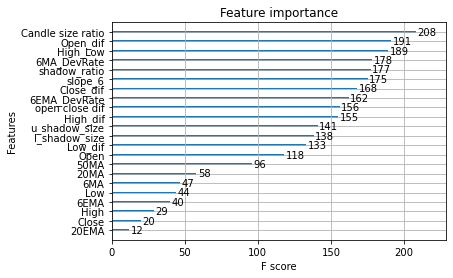

In [209]:
xgb.plot_importance(bst)

In [188]:
pred = bst.predict(xgb_test)
pred  = np.where(pred > 0.5, 1, 0)

## For submit

In [189]:
df_pred = pd.DataFrame({'Date':df_test['Date'],
                       'Pred':pred}
                      )
df_pred = df_pred.set_index('Date')

In [190]:
df_pred

,Pred
Date,
2012-01-19,0
2012-01-20,0
2012-01-23,0
2012-01-24,0
2012-01-25,1
...,...
2019-12-17,1
2019-12-18,1
2019-12-19,1


In [191]:
sample_submission = pd.read_csv('sample_submission.csv', header=None, index_col=0)
sample_submission

,1
0,
2012-01-26,0
2012-02-09,0
2012-02-24,0
2012-03-09,0
2012-03-23,0
...,...
2019-10-25,0
2019-11-08,0
2019-11-22,0


In [192]:
for i in range(len(sample_submission)):
    for j in range(len(df_pred)):
        if sample_submission.index[i] == df_pred.index[j]:
            sample_submission[1][i] = df_pred['Pred'][j]
        else:
            pass

In [193]:
sample_submission.to_csv('submit8.csv', header=None)

## テストデータの予測結果(SIGNATE HP上)
    - Accuracy :0.6700000